This is a starter file of network simulation

## Set file path of mask and illumination profile

In [1]:
mask_filepath='./private_data/Mask_profile_20181016.png'
illumination_filepath='./private_data/Illumination_profile_20181016.png'

## Import the required packages

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from spice.dynamic_pixel import solve_quasi_3D
from spice.dynamic_pixel import get_merged_r_image


	Welcome to Solcore - version 5.5.2
	Copyright (c) 2018, Imperial College London. All rights reserved.
	Software released under the GNU Lesser General Public License.

No module named 'solcore.poisson_drift_diffusion.ddModel'


## Load the pattern of the contact

In [3]:
contactsMask = imread(mask_filepath)
contactsMask=contactsMask[:,:,0]

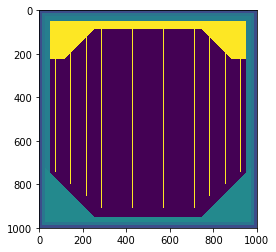

In [4]:
plt.imshow(contactsMask)

## Reduce the shape to 1/2 because of symmetry

In [5]:
nx, ny = contactsMask.shape
contactsMask = contactsMask[:, int(ny / 2):]

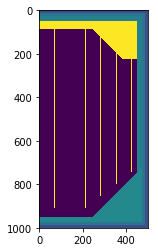

In [6]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [7]:
# both csv and png file are supported.
image_file=illumination_filepath
#image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [8]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [9]:
img=load_illumination(image_file)

NameError: name 'os' is not defined

In [ ]:
plt.imshow(img)

### Show statistics of the profile

Show histogram of pixel values

In [ ]:
plt.hist(img.ravel(),bins=50)
plt.show()

Total of the pixel value:

In [ ]:
value_sum=np.sum(img)
print("The sum of total pixel value: {}".format(value_sum))

In [ ]:
pixel_photon_unit=1.1426e11
print("The sum of photon number: {}".format(value_sum*pixel_photon_unit))

### Reduce the shape to 1/2

In [ ]:
illuminationMask=img
illuminationMask=illuminationMask[:, int(img.shape[1] / 2):]

In [ ]:
plt.imshow(illuminationMask)

In [ ]:
np.max(illuminationMask)

In [ ]:
illuminationMask.shape

## Set solar cell parameters

In [ ]:
# Size of the pixels (m)
Lx = 1e-6
Ly = 1e-6

# Height of the metal fingers (m)
h = 2.2e-6

# Contact resistance (Ohm m2)
Rcontact = 3e-10

# Resistivity metal fingers (Ohm m)
Rline = 2e-8

# Bias (V)
vini = 0
vfin = 3
step = 0.01

T = 298

## Set the parameter of solar cells

This solar cell solver calculates the saturation current J01 and J02 from detail balanced model (assuming 100% aborptivity). Sheet resistance is assigned by the user.

In [ ]:
# the solar cell parameters
ingap_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=0.66, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                       R_shunt=1e16, n=3.5)
gaas_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=1.4, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                        R_shunt=1e16, n=3.5)
ge_cell = Junction(kind='2D', T=T, reff=0.5, jref=300, Eg=1.8, A=1, R_sheet_top=100, R_sheet_bot=100,
                        R_shunt=1e16, n=3.5)

# assign which solar cell to use. For example, to use top cell, set my_solar_cell like this:
# my_solar_cell=SolarCell([ingap_cell],T=T)
# For full 3J solar cell, the parameter is like this:
# my_solar_cell=SolarCell([ingap_cell,gaas_cell,ge_cell],T=T)
my_solar_cell = SolarCell([gaas_cell], T=T)

### Set the light source

In [ ]:
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl, output_units='photon_flux_per_m',
                           concentration=100)

options = {'light_iv': True, 'wavelength': wl, 'light_source': light_source}

In [ ]:
illuminationMask.shape

In [ ]:
contactsMask.shape

### Launch the solver

In [ ]:
pw=20
V, I ,Vall, Vmet= solve_quasi_3D(my_solar_cell, illuminationMask, contactsMask, options=options, Lx=Lx,
                                      Ly=Ly,
                                      h=h,
                                      R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini,
                                      bias_end=vfin,
                                      bias_step=step, sub_cw=pw, sub_rw=pw)

# Since we model 1/4 of the device, we multiply the current by 4
I = I * 2

### Voltage map

In [ ]:
plt.imshow(Vmet[:,:,-1])
plt.colorbar()

### Downsampled image

In [ ]:
r_image=get_merged_r_image(contactsMask,pw,pw)
plt.imshow(r_image)

In [ ]:
plt.semilogy(V, abs(I))
plt.show()

## Plot in linear scale

In [ ]:
plt.plot(V, I)

Zoom in to negative current

In [ ]:
plt.plot(V, I)
plt.ylim([np.min(I)*1.1,0])

## Export the I-V characteristics into a CSV file

The result is written into the file ```iv_result.csv```

In [ ]:
output_iv=np.vstack([V,I]).T
np.savetxt('iv_result.csv',output_iv,delimiter=',')